In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# check GPU availability
import torch
print("available devices count:", torch.cuda.device_count())
# disable CuDNN globally
torch.backends.cudnn.enabled = False

available devices count: 4


In [3]:
import torchvision
import numpy as np
transform = lambda x: torch.from_numpy(np.asarray(x, dtype=np.float32))
mnist_train_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=True, download=True, transform=transform)
mnist_test_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=False, download=True, transform=transform)

In [4]:
class CNN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        kernel_sizes = [5, 5]
        channels = [10, 10]
        self.conv1 = torch.nn.Conv2d(1, channels[0], kernel_sizes[0])
        self.batch_norm1 = torch.nn.BatchNorm2d(channels[0])
        self.conv2 = torch.nn.Conv2d(channels[0], channels[1], kernel_sizes[1])
        fc_input_size = (input_size[0] - sum(kernel_sizes) + len(kernel_sizes)) \
                        * (input_size[0] - sum(kernel_sizes) + len(kernel_sizes)) \
                        * channels[-1]
        self.fc = torch.nn.Linear(fc_input_size, 10)
    
    def forward(self, input):
        x = input.view(input.size()[0], 1, input.size()[1], input.size()[2])
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.conv2(x)
        x = torch.nn.LeakyReLU()(x)
        x = x.view(input.size()[0], -1)
        x = self.fc(x)
        return x

In [5]:
from snippets.scaffold import TrainLoop, TestLoop
# set a GPU device
torch.cuda.set_device(1)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, 
                                                     batch_size=32, 
                                                     shuffle=True, 
                                                     drop_last=True, 
                                                     num_workers=16)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_data, 
                                                     batch_size=1024, 
                                                     shuffle=False, 
                                                     drop_last=False, 
                                                     num_workers=16)
model = CNN(mnist_train_data[0][0].size())
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
with TrainLoop(max_epochs=10, use_cuda=True).with_context() as loop:
    for _ in loop.iter_epochs():
        for _, (x, y) in loop.iter_steps(mnist_train_dataloader):
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            loop.submit_metric("train_loss", loss.detach().cpu().numpy())
        with TestLoop(use_cuda=True, print_fn=None).with_context() as test_loop:
            for _, (x, y) in test_loop.iter_steps(mnist_test_dataloader):
                logits = model(x)
                y_pred = torch.argmax(logits, dim=-1)
                test_loop.submit_data("correct_count", np.asscalar(torch.sum(y_pred == y).cpu().numpy()))
                test_loop.submit_data("total_count", np.asscalar(np.prod(y.size())))
                loop.submit_metric("test_loss", loss_fn(logits, y).cpu().numpy())
            loop.submit_metric("test_accuracy", 
                               sum(test_loop.get_data("correct_count")) / sum(test_loop.get_data("total_count")))

[epoch:1/10 step:1875 ETA:128.808s] train_loss: 0.124736(±0.188896) step_time(s): 0.005603(±0.005340) test_loss: 0.045063 test_accuracy: 0.980500 epoch_time(s): 14.311993
[epoch:2/10 step:3750 ETA:110.555s] train_loss: 0.051864(±0.070950) step_time(s): 0.005394(±0.000568) test_loss: 0.033762 test_accuracy: 0.985500 epoch_time(s): 13.819344
[epoch:3/10 step:5625 ETA:98.201s] train_loss: 0.037198(±0.058099) step_time(s): 0.005455(±0.000770) test_loss: 0.042805 test_accuracy: 0.986800 epoch_time(s): 14.028722
[epoch:4/10 step:7500 ETA:85.692s] train_loss: 0.028584(±0.051508) step_time(s): 0.005521(±0.000625) test_loss: 0.036122 test_accuracy: 0.988300 epoch_time(s): 14.282055
[epoch:5/10 step:9375 ETA:74.863s] train_loss: 0.022183(±0.046612) step_time(s): 0.005759(±0.000908) test_loss: 0.043034 test_accuracy: 0.985000 epoch_time(s): 14.972628
[epoch:6/10 step:11250 ETA:59.118s] train_loss: 0.017769(±0.039576) step_time(s): 0.005712(±0.000789) test_loss: 0.047215 test_accuracy: 0.986000 ep

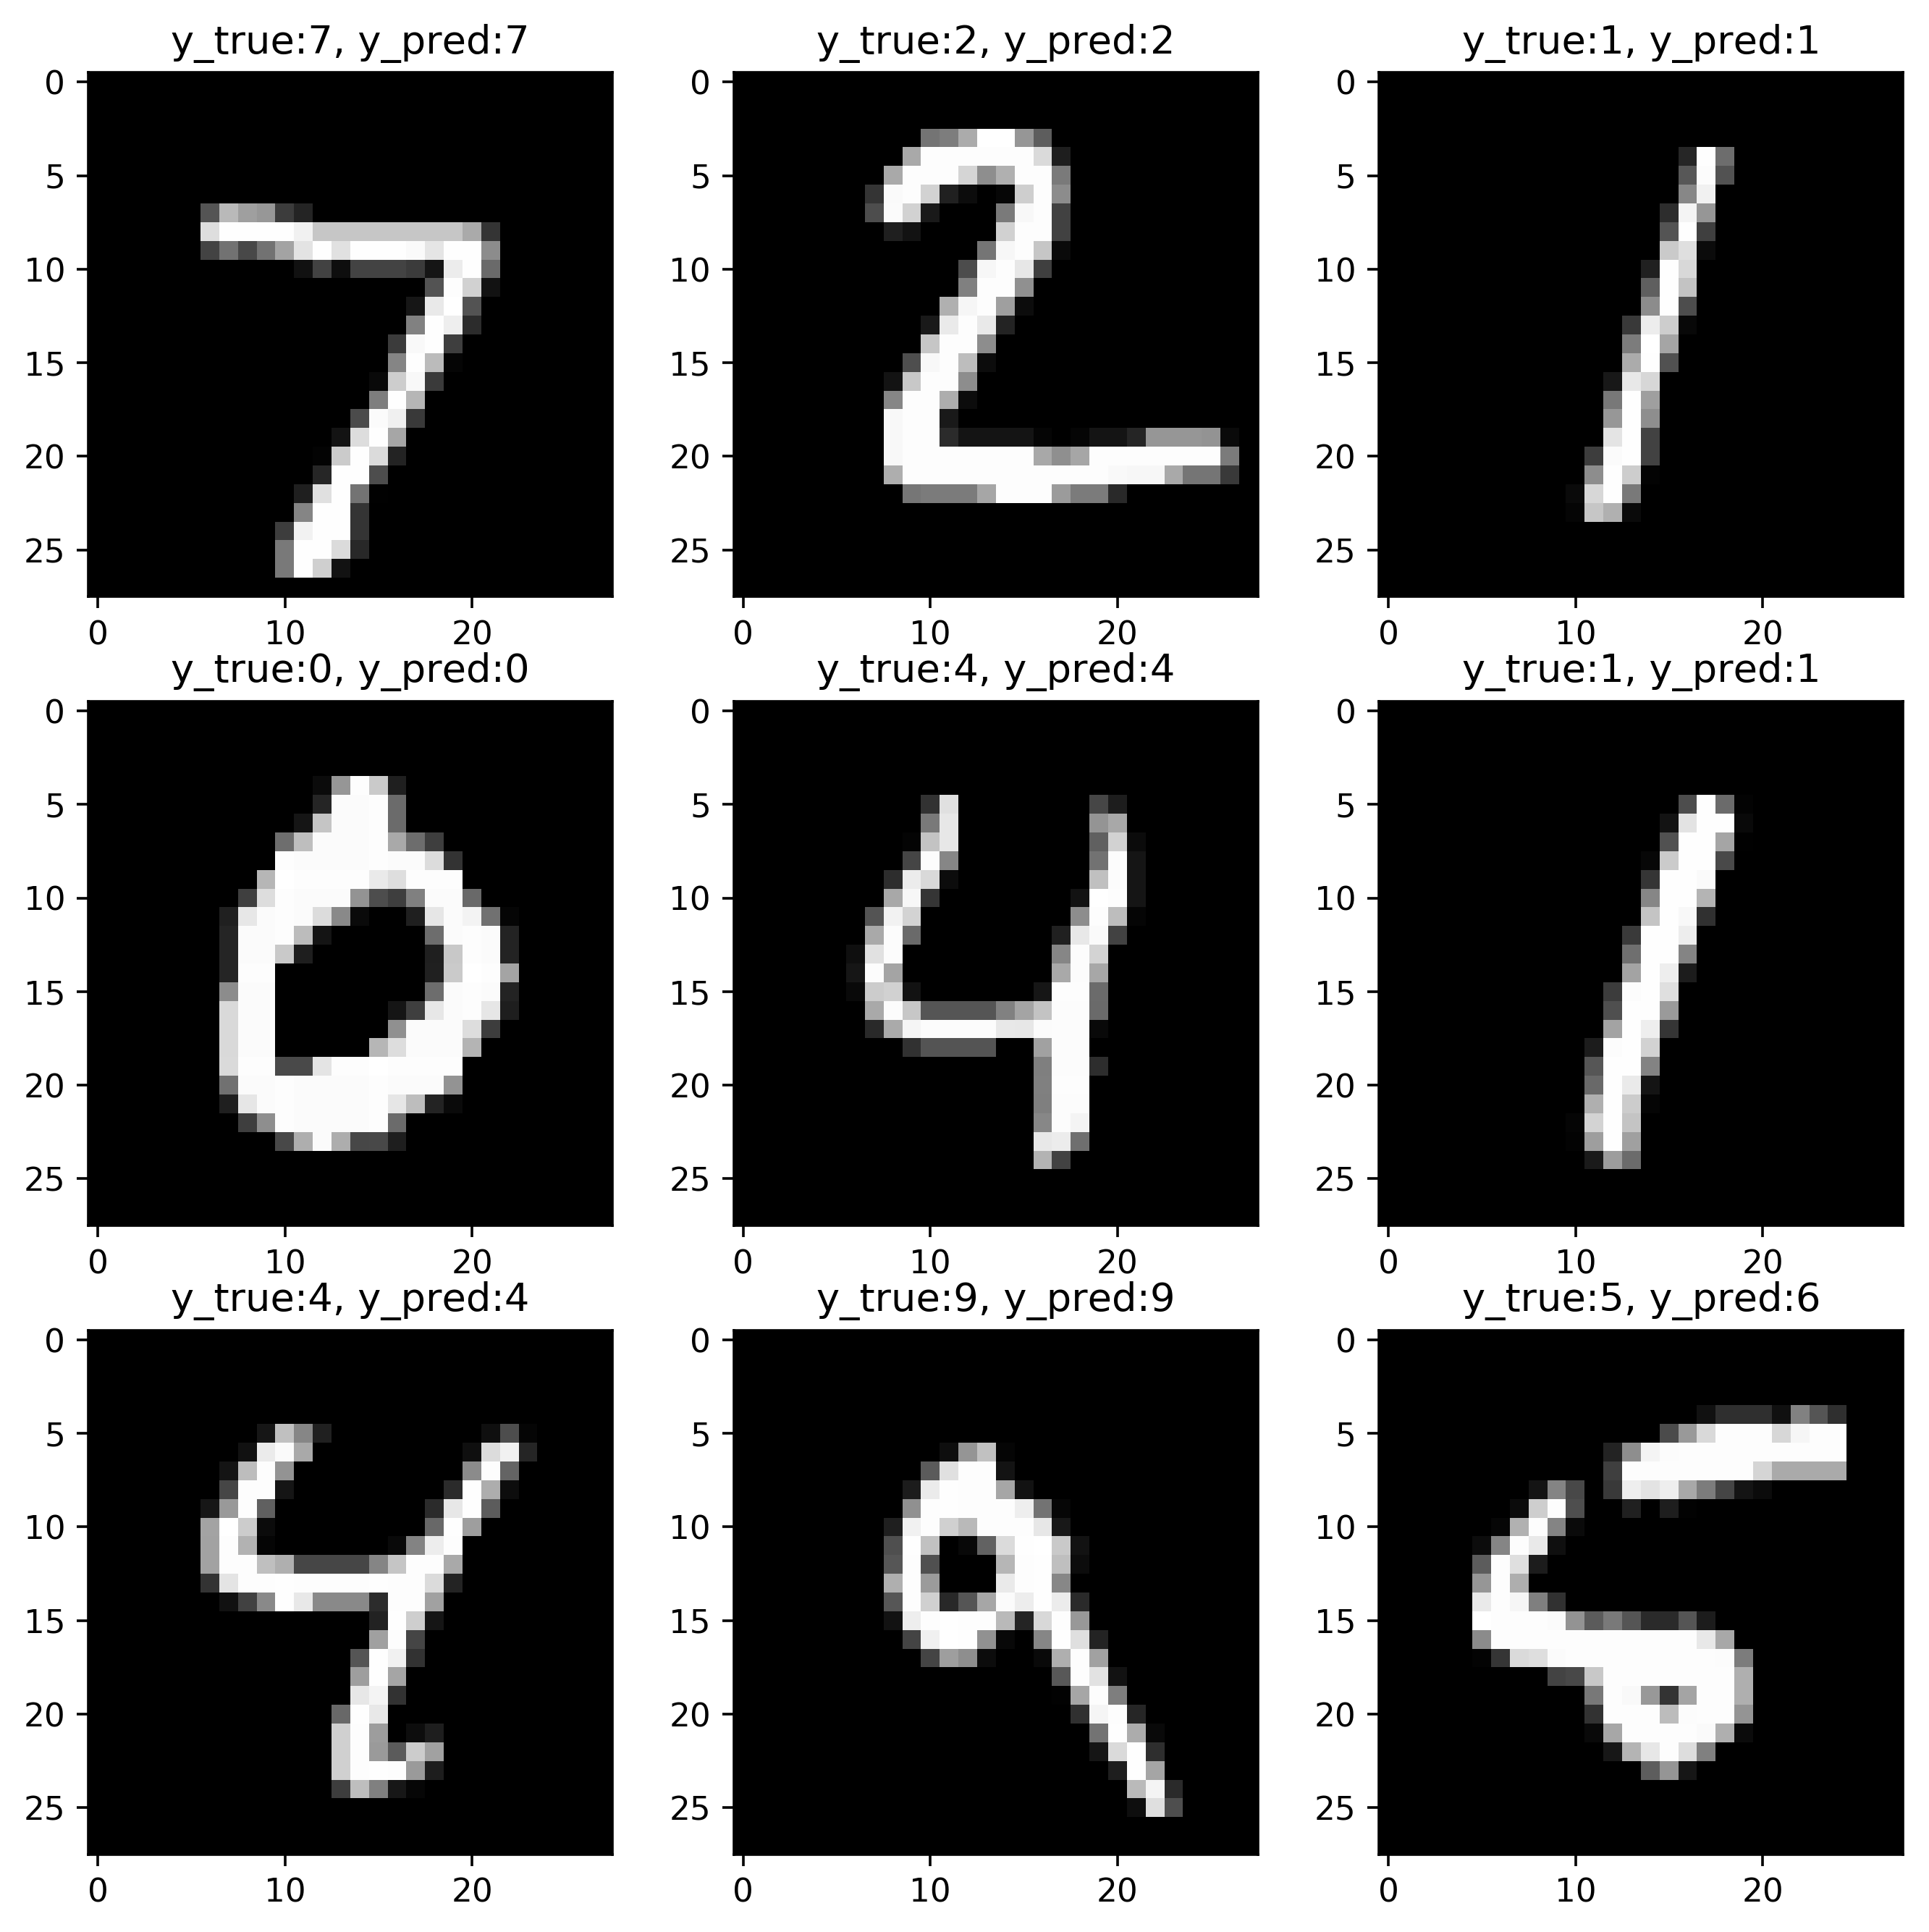

In [6]:
import matplotlib.pyplot as plt
import PIL.Image
fig = plt.figure(figsize=(10, 10), dpi=326)
with torch.no_grad():
    for i in range(9):
        x, y = mnist_test_data[i]
        img = PIL.Image.fromarray(x.numpy())
        plt.subplot(int(f"33{i+1}"))
        plt.imshow(img)
        y_pred = np.argmax(model(torch.unsqueeze(x, 0).cuda()))
        plt.title(f"y_true:{y}, y_pred:{y_pred}")
plt.show()
plt.close("all")